<a href="https://www.kaggle.com/code/konathana/spaceship-titanic-missing-values-strategy?scriptVersionId=208687646" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import catboost as ctb
import xgboost as xgb
from sklearn import metrics
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

**Group Column**

Extracting the Group of each passenger.

In [4]:
df_train['Group'] = df_train['PassengerId'].apply(lambda x: x.split("_")[0])
df_test['Group'] = df_test['PassengerId'].apply(lambda x: x.split("_")[0])

**Check if there any common Groups in Train and Test**

In [5]:
train = list(df_train['Group'].unique());
test = list(df_test['Group'].unique());

In [6]:
l = []
for i in test:
  if i in train:
    l.append(i)

In [7]:
l

[]

There are no common Groups between train and test set.

**Check for NaN Values**

In [8]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
dtype: int64

In [9]:
df_test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Group             0
dtype: int64

**Check for duplicate rows**

In [10]:
print(df_train.duplicated('PassengerId').sum())
print(df_test.duplicated('PassengerId').sum())

0
0


There are no duplicated records in either dataset.

# **Surname Column**

**Filling Name Column**

First, we fill in all the missing values in the "Name" column by the most common full name per Group. This aims towards identifying people with the same surname which will probably mean that they are related and thus, traveling as a group.

In [11]:
df_train['Name'] = df_train['Name'].fillna(df_train.groupby('Group')['Name'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['Name'] = df_test['Name'].fillna(df_test.groupby('Group')['Name'].transform(lambda x: pd.Series.mode(x).get(0)))

In [12]:
df_train['Name'] = df_train['Name'].fillna('Not Available')
df_test['Name'] = df_test['Name'].fillna('Not Available')

In [13]:
def surname(x):
    if x != 'Not Available':
        return x.split(' ')[-1]
    return x

In [14]:
df_train['Surname'] = df_train['Name'].apply(lambda x: surname(x))
df_test['Surname'] = df_test['Name'].apply(lambda x: surname(x))

# **"Home Planet" Filling NaN**

Following the same logical thinking, passengers sharing the same surname and/or group are highly likely to come from the same Home Planet.

In [15]:
df_train['HomePlanet'] = df_train['HomePlanet'].fillna(df_train.groupby('Surname')['HomePlanet'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['HomePlanet'] = df_test['HomePlanet'].fillna(df_test.groupby('Surname')['HomePlanet'].transform(lambda x: pd.Series.mode(x).get(0)))

In [16]:
df_train['HomePlanet'] = df_train['HomePlanet'].fillna(df_train.groupby('Group')['HomePlanet'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['HomePlanet'] = df_test['HomePlanet'].fillna(df_test.groupby('Group')['HomePlanet'].transform(lambda x: pd.Series.mode(x).get(0)))

In [17]:
print(df_train['HomePlanet'].isna().sum())
print(df_test['HomePlanet'].isna().sum())

7
15


There are still some missing values in the "HomePlanet" column. Considering what this column represents, then the Home Planet might not play such a huge impact on whether or not a passenger has been transported. So, we will drop this column.

# **"Cabin" Filling NaN**

Keeping in mind the assumptions made above, passengers sharing the same surname and/or group are highly likely to have similar cabin characteristics e.g. Deck and Side.

In [18]:
df_train['Cabin'] = df_train['Cabin'].fillna(df_train.groupby('Group')['Cabin'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['Cabin'] = df_test['Cabin'].fillna(df_test.groupby('Group')['Cabin'].transform(lambda x: pd.Series.mode(x).get(0)))

In [19]:
df_train['Cabin'] = df_train['Cabin'].fillna(df_train.groupby('Surname')['Cabin'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['Cabin'] = df_test['Cabin'].fillna(df_test.groupby('Surname')['Cabin'].transform(lambda x: pd.Series.mode(x).get(0)))

At this point, there are still some missing values on this column. However, this will be solved in a next step.

# **"Destination" Filling NaN**

Assuming that passengers sharing the same surname and/or group are highly likely to have the same final Destination, we will fill in the null values of the corresponding column.

In [20]:
df_train['Destination'] = df_train['Destination'].fillna(df_train.groupby('Group')['Destination'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['Destination'] = df_test['Destination'].fillna(df_test.groupby('Group')['Destination'].transform(lambda x: pd.Series.mode(x).get(0)))

In [21]:
df_train['Destination'] = df_train['Destination'].fillna(df_train.groupby('Surname')['Destination'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['Destination'] = df_test['Destination'].fillna(df_test.groupby('Surname')['Destination'].transform(lambda x: pd.Series.mode(x).get(0)))

In [22]:
df_test['Destination'].isna().sum()

14

<AxesSubplot:xlabel='HomePlanet', ylabel='Count'>

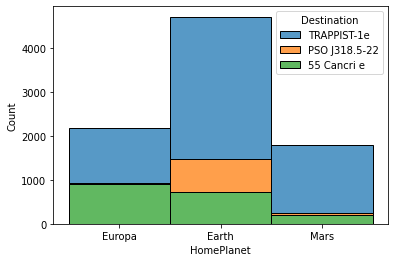

In [23]:
sns.histplot(binwidth=0.5, x="HomePlanet", hue="Destination", data=df_train, stat="count", multiple="stack")

# **"VIP" Filling NaN**

In [24]:
df_train['VIP'] = df_train['VIP'].fillna(df_train.groupby('Group')['VIP'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['VIP'] = df_test['VIP'].fillna(df_test.groupby('Group')['VIP'].transform(lambda x: pd.Series.mode(x).get(0)))

In [25]:
df_train['VIP'] = df_train['VIP'].fillna(df_train.groupby('Surname')['VIP'].transform(lambda x: pd.Series.mode(x).get(0)))
df_test['VIP'] = df_test['VIP'].fillna(df_test.groupby('Surname')['VIP'].transform(lambda x: pd.Series.mode(x).get(0)))

# **Filling the remaining Nan "Cabin" Cells**

In [26]:
df_c_train=df_train[df_train['Cabin'].notna()]
df_c_train['Side'] = df_c_train['Cabin'].apply(lambda x: x.split("/")[-1])
df_c_train.groupby('Side')['Side'].count()

Side
P    4295
S    4389
Name: Side, dtype: int64

<AxesSubplot:xlabel='Deck'>

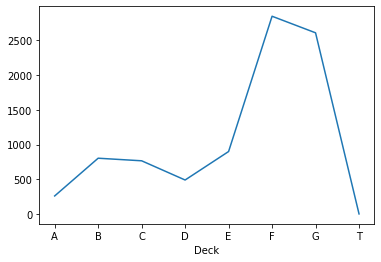

In [27]:
df_c_train['Deck'] = df_c_train['Cabin'].apply(lambda x: x.split("/")[0])
df_c_train.groupby('Deck')['Deck'].count().plot()

<AxesSubplot:xlabel='Side', ylabel='Count'>

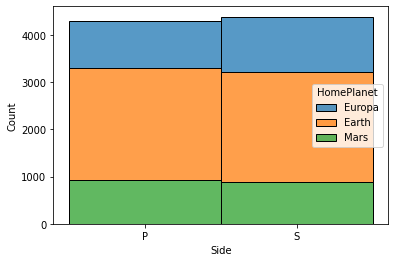

In [28]:
sns.histplot(binwidth=0.5, x="Side", hue="HomePlanet", data=df_c_train, stat="count", multiple="stack")

<AxesSubplot:xlabel='Side', ylabel='Count'>

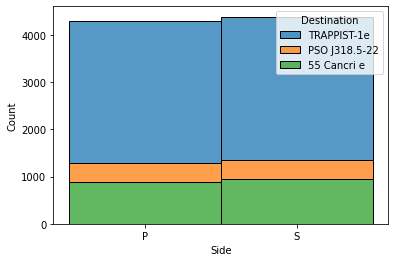

In [29]:
sns.histplot(binwidth=0.5, x="Side", hue="Destination", data=df_c_train, stat="count", multiple="stack")

<AxesSubplot:xlabel='Deck', ylabel='Count'>

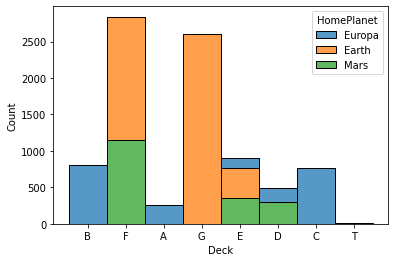

In [30]:
sns.histplot(binwidth=0.5, x="Deck", hue="HomePlanet", data=df_c_train, stat="count", multiple="stack")

<AxesSubplot:xlabel='Deck', ylabel='Count'>

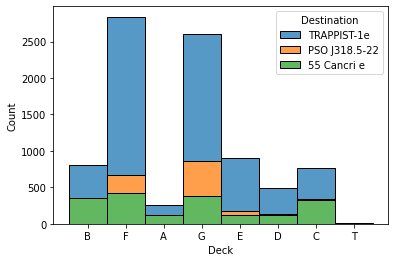

In [31]:
sns.histplot(binwidth=0.5, x="Deck", hue="Destination", data=df_c_train, stat="count", multiple="stack")

In [32]:
total_c_train = df_c_train.groupby('Deck')['Deck'].count().sum()

In [33]:
df_c_train.groupby('Deck')['Deck'].count()/total_c_train

Deck
A    0.030286
B    0.092699
C    0.088439
D    0.056656
E    0.103754
F    0.327499
G    0.300092
T    0.000576
Name: Deck, dtype: float64

In [34]:
df_c_test=df_test[df_test['Cabin'].notna()]
df_c_test['Side'] = df_c_test['Cabin'].apply(lambda x: x.split("/")[-1])
df_c_test.groupby('Side')['Side'].count()

Side
P    2124
S    2137
Name: Side, dtype: int64

<AxesSubplot:xlabel='Deck'>

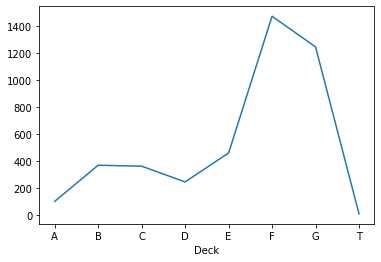

In [35]:
df_c_test['Deck'] = df_c_test['Cabin'].apply(lambda x: x.split("/")[0])
df_c_test.groupby('Deck')['Deck'].count().plot()

In [36]:
total_c_test = df_c_test.groupby('Deck')['Deck'].count().sum()

In [37]:
df_c_test.groupby('Deck')['Deck'].count()/total_c_test

Deck
A    0.023234
B    0.086365
C    0.084722
D    0.057264
E    0.107721
F    0.346398
G    0.292889
T    0.001408
Name: Deck, dtype: float64

We notice that there is a pattern on the order of the deck the passengers are assigned to based on their HomePlanet e.g.
A,B,C,D,E and T --> Europa
D,E,F --> Mars
E,F,G --> Earth

We can assume that the spaceship starts from Europa, then stops to Mars, and finally to Earth to pick up the passengers. Thus, for example, decks A,B, and C are already full when the spaceship arrives in Mars since these decks have been occupied by passengers coming from Europa.

In [38]:
def deck(x):
    if type(x) == float:
        return x
    return x.split('/')[0]

In [39]:
df_train['Deck'] = df_train['Cabin'].apply(lambda x: deck(x))
df_test['Deck'] = df_test['Cabin'].apply(lambda x: deck(x))

In [40]:
def side(x):
    if type(x) == float:
        return x
    return x.split('/')[-1]

In [41]:
df_train['Side'] = df_train['Cabin'].apply(lambda x: side(x))
df_test['Side'] = df_test['Cabin'].apply(lambda x: side(x))

In [42]:
def fill_homeplanet(x):
    if (x == 'A' or x == 'B' or x == 'C' or x == 'T'):
        return 'Europa'
    elif (x == 'D' or x == 'E'):
        return 'Mars'
    elif (x == 'F' or x == 'G'):
        return 'Earth'

In [43]:
df_train['HomePlanet'] = df_train['HomePlanet'].fillna(df_train['Deck'].apply(lambda x: fill_homeplanet(x)))
df_test['HomePlanet'] = df_test['HomePlanet'].fillna(df_test['Deck'].apply(lambda x: fill_homeplanet(x)))

In [44]:
def fill_deck(x):
    if x == 'Europa':
        return random.choice(['A', 'B', 'C', 'T'])
    elif x == 'Mars':
        return random.choice(['D', 'E'])
    elif x == 'Earth':
        return random.choice(['F', 'G'])

In [45]:
df_train['Deck'] = df_train['Deck'].fillna(df_train['HomePlanet'].apply(lambda x: fill_deck(x)))
df_test['Deck'] = df_test['Deck'].fillna(df_test['HomePlanet'].apply(lambda x: fill_deck(x)))

In [46]:
df_train['Side'] = df_train['Side'].fillna('P')
df_test['Side'] = df_test['Side'].fillna('P')

# **Bill Column**

In [47]:
df_train.update(df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0))
df_test.update(df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0))

In [48]:
df_train['Bill'] = df_train.apply(lambda x: x['RoomService'] + x['FoodCourt'] + x['ShoppingMall'] + x['Spa'] + x['VRDeck'], axis=1)
df_test['Bill'] = df_test.apply(lambda x: x['RoomService'] + x['FoodCourt'] + x['ShoppingMall'] + x['Spa'] + x['VRDeck'], axis=1)

# **"CryoSleep" Filling NaN**

Passengers with 0 luxury amenities bill are probably in cryosleep state.

In [49]:
def cryosleep(x):
  if x == 0:
      return True
  return False

In [50]:
df_train['CryoSleep'] = df_train['CryoSleep'].fillna(df_train['Bill'].apply(lambda x: cryosleep(x)))
df_test['CryoSleep'] = df_test['CryoSleep'].fillna(df_test['Bill'].apply(lambda x: cryosleep(x)))

<AxesSubplot:xlabel='VIP', ylabel='Count'>

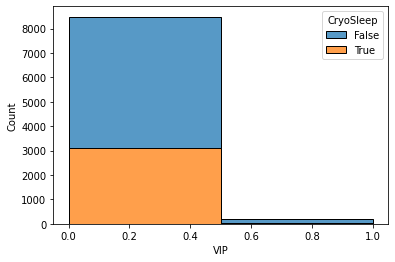

In [51]:
sns.histplot(binwidth=0.5, x="VIP", hue="CryoSleep", data=df_train, stat="count", multiple="stack")

In [52]:
df_train.groupby('VIP')['Bill'].mean()

VIP
False    1369.143261
True     4425.477387
Name: Bill, dtype: float64

By examining the dataset, we observe that the VIP passengers that are also in CryoSleep state all come from Europa. So we fill the remaining missing values in the VIP column by keeping this in mind and by comparing the total bill to the mean value per VIP/non-VIP group.

In [53]:
def fill_vip(x,y,z):
    if (x == 'Europa' and y == True) or z >= 4425.477387:
        return True
    return False

In [54]:
df_train['VIP'] = df_train['VIP'].fillna(df_train.apply(lambda x: fill_vip(x['HomePlanet'], x['CryoSleep'], x['Bill']), axis=1))
df_test['VIP'] = df_test['VIP'].fillna(df_test.apply(lambda x: fill_vip(x['HomePlanet'], x['CryoSleep'], x['Bill']), axis=1))

# **"Age" Filling NaN**

(array([ 947., 3217., 2491., 1233.,  542.,   84.]),
 array([ 0.        , 13.16666667, 26.33333333, 39.5       , 52.66666667,
        65.83333333, 79.        ]),
 <BarContainer object of 6 artists>)

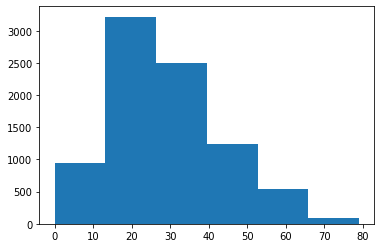

In [55]:
plt.hist(df_train['Age'], bins=6)

In [56]:
df_train[df_train['Age']<=12]['Bill'].max()

0.0

# **Defining Age Group Categories**

In [57]:
def age_group(x):
  if x < 13:
    return 'Kid'
  elif x < 18:
    return 'Teen'
  elif x < 26:
    return 'Young_Adult'
  elif x < 41:
    return 'Adult'
  elif x < 66:
    return 'Senior'
  else:
    return 'Elderly'  

In [58]:
df_train['AgeGroup'] = df_train['Age'].apply(lambda x: age_group(x))
df_test['AgeGroup'] = df_test['Age'].apply(lambda x: age_group(x))

In [59]:
df_train.groupby('AgeGroup')['Bill'].mean().round()

AgeGroup
Adult          1990.0
Elderly        1632.0
Kid               0.0
Senior         1899.0
Teen            834.0
Young_Adult    1108.0
Name: Bill, dtype: float64

In [60]:
def fill_age_group(x):
    if x == 0:
        return 'Kid'
    elif x <= 834:
        return 'Teen'
    elif x <= 1108:
        return 'Young_Adult'
    elif x <= 1632:
        return 'Elderly'
    elif x <= 1899:
        return 'Senior'
    else:
        return 'Adult'

In [61]:
df_train['AgeGroup'] = df_train['AgeGroup'].fillna(df_train['Bill'].apply(lambda x: fill_age_group(x)))
df_test['AgeGroup'] = df_test['AgeGroup'].fillna(df_test['Bill'].apply(lambda x: fill_age_group(x)))

In [62]:
df_train.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             9
Destination       7
Age             179
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
Transported       0
Group             0
Surname           0
Deck              0
Side              0
Bill              0
AgeGroup          0
dtype: int64

In [63]:
df_test.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin           16
Destination     14
Age             91
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Name             0
Group            0
Surname          0
Deck             0
Side             0
Bill             0
AgeGroup         0
dtype: int64

# **Dropping not useful columns**

In [64]:
drop_columns = ['PassengerId','Age','Destination','HomePlanet','Group','Cabin','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Bill','Name','Surname']

df_train = df_train.drop(drop_columns, axis=1)
df_test_ids = df_test['PassengerId']
df_test = df_test.drop(drop_columns, axis=1)

In [65]:
df_train.isna().sum()

CryoSleep      0
VIP            0
Transported    0
Deck           0
Side           0
AgeGroup       0
dtype: int64

In [66]:
df_test.isna().sum()

CryoSleep    0
VIP          0
Deck         0
Side         0
AgeGroup     0
dtype: int64

# **Categorical Values Formatting in 0 and 1**

In [67]:
df_train['CryoSleep'] = df_train['CryoSleep'].replace(False,0).replace(True,1)
df_train['VIP'] = df_train['VIP'].replace(False,0).replace(True,1)
df_train['Transported'] = df_train['Transported'].replace(False,0).replace(True,1)

df_test['CryoSleep'] = df_test['CryoSleep'].replace(False,0).replace(True,1)
df_test['VIP'] = df_test['VIP'].replace(False,0).replace(True,1)

In [68]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# **X, y and train, test datasets splitting** 

In [69]:
X = df_train.drop(['Transported'], axis=1)
y = df_train['Transported']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
X_train.columns

Index(['CryoSleep', 'VIP', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Side_P', 'Side_S', 'AgeGroup_Adult',
       'AgeGroup_Elderly', 'AgeGroup_Kid', 'AgeGroup_Senior', 'AgeGroup_Teen',
       'AgeGroup_Young_Adult'],
      dtype='object')

# **Models**

## **XGB Classifier**

In [72]:
xb = xgb.XGBClassifier(max_depth=5)
xb.fit(X_train, y_train)
y_pred = xb.predict(X_test)

#Accuracy
print("Accuracy:",format(metrics.accuracy_score(y_test, y_pred),'.4f'))
#Precision
print("Precision:",format(metrics.precision_score(y_test, y_pred),'.4f'))
#Sensitivity
print("Sensitivity:",format(metrics.recall_score(y_test, y_pred),'.4f'))

Accuracy: 0.7361
Precision: 0.7820
Sensitivity: 0.6617


## **SVC**

In [73]:
s = SVC(kernel='linear')
s.fit(X_train, y_train)
y_pred = s.predict(X_test)

#Accuracy
print("Accuracy:",format(metrics.accuracy_score(y_test, y_pred),'.4f'))
#Precision
print("Precision:",format(metrics.precision_score(y_test, y_pred),'.4f'))
#Sensitivity
print("Sensitivity:",format(metrics.recall_score(y_test, y_pred),'.4f'))

Accuracy: 0.7441
Precision: 0.7946
Sensitivity: 0.6651


## **Random Forest**

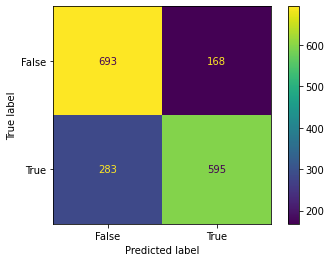

Accuracy: 0.7407
Precision: 0.7798
Sensitivity: 0.6777


In [74]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
tn, fp, fn, tp = confusion_matrix.ravel()

#Accuracy
print("Accuracy:",format(metrics.accuracy_score(y_test, y_pred),'.4f'))
#Precision
print("Precision:",format(metrics.precision_score(y_test, y_pred),'.4f'))
#Sensitivity
print("Sensitivity:",format(metrics.recall_score(y_test, y_pred),'.4f'))

**Creating the Submission File based on the most optimal model predictions**

In [75]:
predicted = rf.predict(df_test)

In [76]:
df = pd.DataFrame(columns=['PassengerId','Transported'])
df['PassengerId'] = df_test_ids
df['Transported'] = predicted

In [77]:
df['Transported'] = df['Transported'].map({0:False, 1:True})

In [78]:
df.to_csv('sample_submission.csv', index=False)